# DS4440: HW3

In this homework, we'll do some real "interpretability" type stuff! In particular, we'll start with a simple MLP for MNIST image classification, and then

We've covered what you need from ``NNSight`` in lectures, but here's a [refresher notebook](https://colab.research.google.com/drive/1SdEDGoJ0eN0ADuYhpjBfsDdVYP6texv_?usp=sharing) that should give you what you need here!

# Starter code

This is code we saw in lecture (on "[computation graphs](https://colab.research.google.com/drive/1VPe3-pTjEFiNyxBGCTD8pCAxGEuqyFJ2#scrollTo=5Ri9lvFnlmqs)").

In [1]:
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim

import sklearn
from sklearn.metrics import accuracy_score

import numpy as np


# we need to convert images to tensors; this is very naive
img_transform = transforms.Compose([
    transforms.ToTensor()
])

MNIST_train = datasets.MNIST(root='./data', train=True, download=True,
                             transform=transforms.ToTensor())

# remove last 16 elements from x and y
print(len(MNIST_train))
MNIST_test = datasets.MNIST(root='./data', train=False, download=True,
                            transform=transforms.ToTensor())
MNIST_test = torch.utils.data.Subset(MNIST_test, range(len(MNIST_test)-16))
print(len(MNIST_test))

train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size=32)

60000
9984


In [2]:
class MLP(nn.Module):

  def __init__(self):
    super().__init__() # the correct (tm) way!
    self.i = nn.Linear(28**2, 32)
    self.a = nn.Sigmoid()
    self.o = nn.Linear(32, 10)
    self.sm = nn.Softmax(dim=1)

  def forward(self, X):

    # the reason we do this is because MNIST images
    # have dimension (1 x 28 x 28), so X will have
    # dims (BATCH_SIZE x 1 x 28 x 28) -- we collapse
    # them here.
    X = X.view(-1, 28**2)

    h = self.i(X)
    h = self.a(h)
    y_hat = self.o(h)
    y_hat = self.sm(y_hat)
    return y_hat

In [3]:
def train(m, train_data, epochs=10, learning_rate=.5, cuda=True):
  optimizer = optim.SGD(m.parameters(), lr=learning_rate)
  L = torch.nn.CrossEntropyLoss() # our loss

  for epoch in range(epochs):
      epoch_loss = 0
      for batch_index, (X, y) in enumerate(train_data):
        if cuda: 
          X, y = X.cuda(), torch.tensor([y]).cuda()
        else: 
           y = torch.tensor([y])
        #print(f'Shape of X: {X.shape}')

        # don't forget to do this!!
        optimizer.zero_grad()

        # make our predictions, under current weights
        y_hat = m(X)

        # run through our loss function, given y
        loss = L(y_hat, y)

        # take a backward pass through computation
        # graph; this is where the auto-diff happens!
        loss.backward()

        # accumulate loss
        epoch_loss += loss.item()

        # step the optimizer -- update our params
        # using accumulated gradients.
        optimizer.step()

      print("epoch loss", epoch_loss)


In [5]:
m = MLP()
train(m, MNIST_train, epochs=10, cuda=False)

epoch loss 94987.84805381298
epoch loss 92619.95573306084
epoch loss 92257.56221282482
epoch loss 91863.86717450619
epoch loss 91827.43284165859
epoch loss 91575.05970144272
epoch loss 91451.54112029076
epoch loss 91414.57807600498
epoch loss 91390.75984716415
epoch loss 91349.93161725998


In [6]:
def batch_make_preds(m, dataloader, cuda=False):
    y_hat_test, y_true = [], []
    for i, (X, y) in enumerate(dataloader):
        if cuda: 
            preds = m(X.cuda()).detach().cpu().numpy()
            y_hat_test.extend(np.argmax(preds, axis=1))
            y_true.extend(y.cpu().numpy())
        else:
            preds = m(X).detach().numpy()
            y_hat_test.extend(np.argmax(preds, axis=1))
            y_true.extend(y.numpy())
    return y_hat_test, y_true

In [7]:
y_hat_test, y_true = batch_make_preds(m, test_loader, cuda=False)
print(accuracy_score(y_hat_test, y_true))

0.9376001602564102


# Q1 (10 pts): More layerz

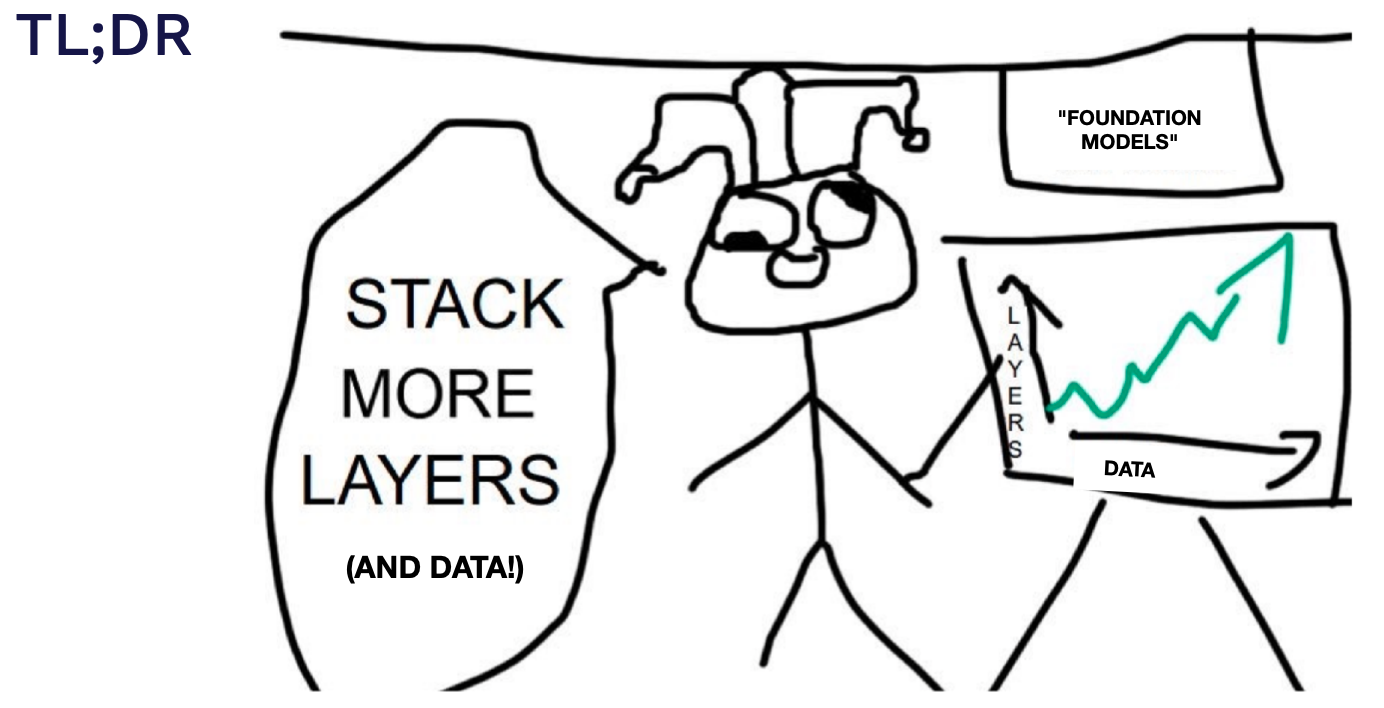

Create a new version of the MLP above (call it `MLP2`) by introducing an additional hidden layer, make it 16 dimensions. Be sure to use a non-linear activation. Verify that you get "reasonable" performance (say $> .9$ accuracy) with this version. This may require additional epochs.

In [8]:
class MLP2(nn.Module):

  def __init__(self):
    super().__init__()
    # TODO
    self.l1 = nn.Linear(28**2, 32)
    self.l2 = nn.Sigmoid()
    self.l3 = nn.Linear(32, 16)
    self.l4 = nn.Sigmoid()
    self.l5 = nn.Linear(16, 10)
    self.sm = nn.Softmax(dim=1)

  def forward(self, X):

    # the reason we do this is because MNIST images
    # have dimension (1 x 28 x 28), so X will have
    # dims (BATCH_SIZE x 1 x 28 x 28) -- we collapse
    # them here.
    X = X.view(-1, 28**2)

    # TODO
    h = self.l1(X)
    h = self.l2(h)
    h = self.l3(h)
    h = self.l4(h)
    y_hat = self.l5(h)
    y_hat = self.sm(y_hat)
    return y_hat

In [11]:
m2 = MLP2()
train(m2, MNIST_train, epochs=10, learning_rate=0.1, cuda=False)

epoch loss 109628.56445360184
epoch loss 96839.23625743389
epoch loss 94105.30117118359
epoch loss 91216.43826210499
epoch loss 90764.91258776188
epoch loss 90537.29492533207
epoch loss 90364.42195510864
epoch loss 90223.26474022865
epoch loss 90088.6846716404
epoch loss 90032.6961607933


In [12]:
y_hat_test, y_true = batch_make_preds(m2, test_loader, cuda=False)
print(accuracy_score(y_hat_test, y_true))

0.9543269230769231


# Q2 (50 pts): Probing (or, what's in the first hidden layer?)

One question that comes up in interpretability work often is: What information do learned representations store? Here you will see if you can, with a single linear layer, decode MNIST class labels from the first hidden layer in your modified MLP (`MLP2`).

Specifically, your task is to:

* Assemble a bunch of (`x`, `y`) pairs from the training data where `x` is the *first* hidden state, following the activation. As a sanity check, also implement a version where you use the penultimate hidden layer---the results here should be ~the same as for `MLP2` itself (why?)
* Train a classification model using this data, but the `x` values should be **frozen**, i.e., you are not to backprop through `MLP2`!
* Evaluate the performance of this on both the train and test `MNIST` data. How well are you able to do?

In [13]:
!pip3 install nnsight
import nnsight
from nnsight import NNsight

Defaulting to user installation because normal site-packages is not writeable


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def batch_make_Xy(m, dataloader, use_first_hiddens=True, cuda=False):
  '''
  Assemble "inputs" as hidden states for all batches in dataloader; also
  return batched labels for convienence.

  If use_first_hiddens is True, you should take the activations at the
  first layer (after activations). Otherwise, take the activations at the
  second (penultimate) layer.
  '''
  Xh, y_probes = [], []
  model = NNsight(m)
  model.zero_grad()
  '''
  TODO!
  - Iterate over all batches in the train loader, and for each *use nnsight*
    to save hidden state actions at either the first or second layer (following
    activations)
  - Also assemble the corresponding target labels (ys)
  - Return both these X vectors and targets; be sure that the activations
    are *detached* from the computation graph!
  '''
  # TODO
  for (X, y) in dataloader:
    if cuda:
      X, y = X.cuda(), y.cuda()
    y_probes.append(y)
    
    with model.trace(X) as tracer:
      if use_first_hiddens:
        hidden_states = tracer.l1.output.detach().save()
      else:
        hidden_states = tracer.l3.output.detach().save()
      Xh.append(hidden_states)

  # Assuming Xh = activation vectors, and y_probes corresponding labels
  return Xh, y_probes

In [15]:
print("making train data...")
train_Xh, train_y_probes = batch_make_Xy(m2, train_loader)
print("done. making test data... ")
test_Xh, test_y_probes = batch_make_Xy(m2, test_loader)

making train data...
done. making test data... 


In [16]:
class ProbeModel(nn.Module): 

    def __init__(self, input_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 10)

    def forward(self, X):
        return self.l1(X)
        

In [ ]:
class ProbeDataset(torch.utils.data.Dataset):
  # TODO implement this bit to provide a nice
  # interface to your (X, y) data
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

probe_train_dataset = ProbeDataset(train_Xh, train_y_probes)
probe_test_dataset = ProbeDataset(test_Xh, test_y_probes)

In [18]:
input_shape = train_Xh[0].shape[0]
# TODO define a probing model
probe_model = ProbeModel((probe_train_dataset.X[0]).shape[0]).cuda()

In [23]:
def trainProbe(m, train_data, epochs=10, learning_rate=0.5, cuda=True):
    optimizer = optim.SGD(m.parameters(), lr=learning_rate)
    L = torch.nn.CrossEntropyLoss()
    
    for epoch in range(epochs): 
        epoch_loss = 0 
        for batch_index, (X, y) in enumerate(train_data):
            if cuda:
                X, y = X.cuda(), y.cuda()
            optimizer.zero_grad()
            y_hat = m(X)
            loss = L(y_hat, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        print("epoch loss", epoch_loss)

trainProbe(probe_model, probe_train_dataset, epochs=10, learning_rate=0.1, cuda=False)

epoch loss 6269.483564585946
epoch loss 6310.406659080977
epoch loss 6316.381789366209
epoch loss 6242.849526130698
epoch loss 6279.248211693079
epoch loss 6244.853779933895
epoch loss 6226.899953716425
epoch loss 6270.196515801223
epoch loss 6315.265190103366
epoch loss 6317.075008555598


In [24]:
y_hat_probe_test, y_probe_true = batch_make_preds(probe_model, probe_test_dataset, cuda=False)
print(accuracy_score(y_hat_probe_test, y_probe_true))

0.7686298076923077


# Q3 (40 pts): Visualizing representations and gradients

Finally, let's visualize some model internals. In particular, the ask here is for you to: Assemble hidden states and gradients (separately) of the hidden layer in `MLP2` over *over the test set* for different classes (digits), dimensionality reduce them, and then plot them.

We use ``NNsight`` to access both hidden representations and their gradients.

In [30]:
def visualizeData(m, dataloader, cuda=True):
    grads, hiddens, ys = [],[],[]
    for (X, y) in dataloader: 
        if cuda: 
            X, y = X.cuda(), y.cuda()
        ys.append(y)

        with m.trace(X): 
            hidden_states = m.l1.output.detach().save()
            hiddens.append(hidden_states)
            hidden_grads = m.l1.output.grad.detach().save()
            grads.append(hidden_grads)
            loss = m.output.sum()
            loss.backward()
    return grads, hiddens, ys

model = NNsight(m2)
grads, hiddens, ys = visualizeData(model, test_loader, cuda=False)

In [31]:
grads_np = np.concatenate(grads)
hiddens_np = np.concatenate(hiddens)
y_list = np.concatenate(ys)

In [32]:
from sklearn.manifold import TSNE

In [33]:
grads_embedded = TSNE(n_components=2).fit_transform(grads_np)

In [34]:
hiddens_embedded = TSNE(n_components=2).fit_transform(hiddens_np)

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

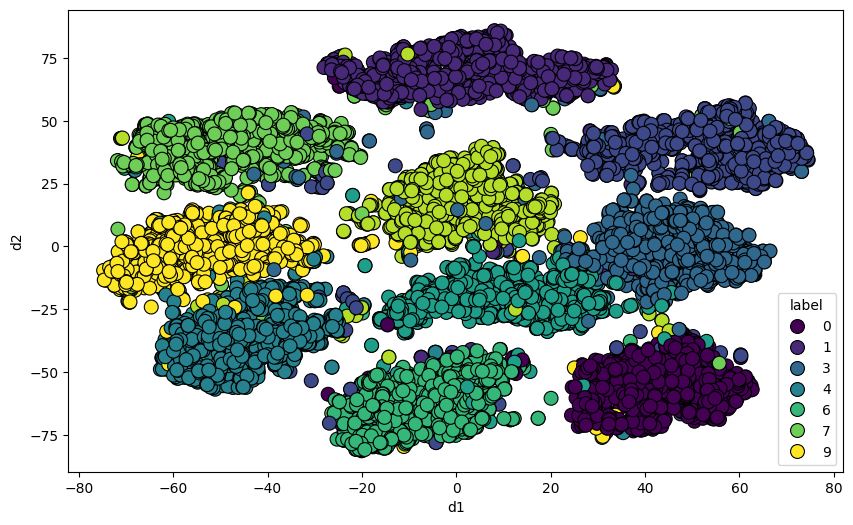

In [37]:
df = pd.DataFrame(hiddens_embedded, columns=['d1', 'd2'])
df['label'] = y_list

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df, x='d1', y='d2', hue='label',
                               palette='viridis', s=100, edgecolor='k')

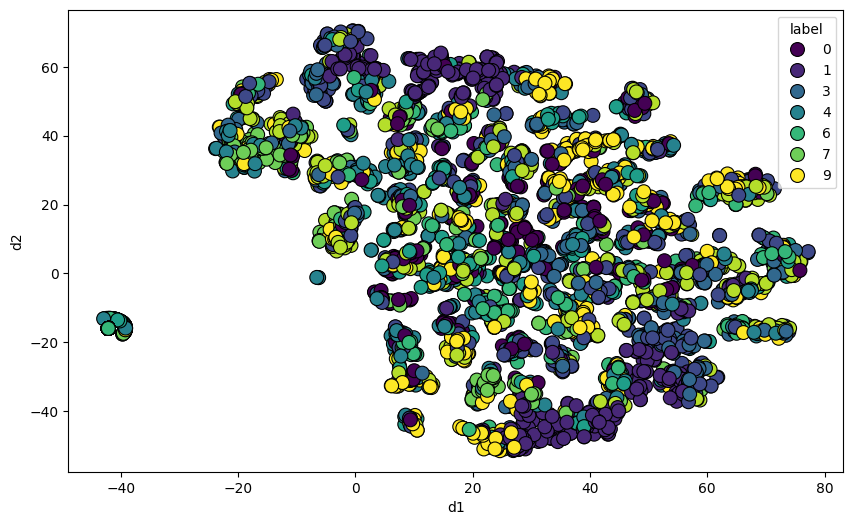

In [38]:
# Grads
df = pd.DataFrame(grads_embedded, columns=['d1', 'd2'])
df['label'] = y_list

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df, x='d1', y='d2', hue='label',
                               palette='viridis', s=100, edgecolor='k')


*Observations* TODO enter comments about the above plots / your interpretation.